<a href="https://colab.research.google.com/github/cdedow/Dedow_FinalProject/blob/main/FinalProject_Dedow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

filedir = '/content/drive/MyDrive/FWE458/'

df_def = filedir + "forest-land-clearing_country_emissions_v4_1_0.csv"
df_fires = filedir + "forest-land-fires_country_emissions_v4_1_0.csv"
df_removals = filedir + "removals_country_emissions_v4_1_0.csv"

# Load the data into Pandas DataFrames
df_fires = pd.read_csv(df_fires)
df_def = pd.read_csv(df_def)
df_removals = pd.read_csv(df_removals)

Mounted at /content/drive


In [ ]:
# Step 1: Select relevant columns and rename emissions_quantity for clarity
df_fires = df_fires[['iso3_country', 'end_time', 'emissions_quantity']].rename(columns={'emissions_quantity': 'fire_emissions'})
df_def = df_def[['iso3_country', 'end_time', 'emissions_quantity']].rename(columns={'emissions_quantity': 'deforestation_emissions'})
df_removals = df_removals[['iso3_country', 'end_time', 'emissions_quantity']].rename(columns={'emissions_quantity': 'removals'})

# Step 2: Convert end_time to datetime and extract year
for df in [df_fires, df_def, df_removals]:
    df['year'] = pd.to_datetime(df['end_time']).dt.year
    df.drop(columns='end_time', inplace=True)

# Step 3: Merge the datasets
merged_df = df_fires.merge(df_def, on=['iso3_country', 'year'], how='outer')
merged_df = merged_df.merge(df_removals, on=['iso3_country', 'year'], how='outer')

# Display a preview of the merged dataset
merged_df.head()

iso3_country  fire_emissions  year  deforestation_emissions      removals
0          ABW             0.0  2015                67.624447  51043.762850
1          ABW             0.0  2016                21.192734  17745.208084
2          ABW             0.0  2017                17.069173 -11764.488834
3          ABW             0.0  2018                88.935862 -23950.412939
4          ABW             0.0  2019                 4.159804  -3824.464692

In [ ]:
# Step 1: Calculate net emissions
merged_df['net_emissions'] = (
    merged_df['fire_emissions'].fillna(0) +
    merged_df['deforestation_emissions'].fillna(0) -
    merged_df['removals'].fillna(0)
)

# Display a few rows with the new metric
merged_df.head()


iso3_country  fire_emissions  year  deforestation_emissions      removals  \
0          ABW             0.0  2015                67.624447  51043.762850   
1          ABW             0.0  2016                21.192734  17745.208084   
2          ABW             0.0  2017                17.069173 -11764.488834   
3          ABW             0.0  2018                88.935862 -23950.412939   
4          ABW             0.0  2019                 4.159804  -3824.464692   

   net_emissions  
0  -50976.138403  
1  -17724.015350  
2   11781.558007  
3   24039.348801  
4    3828.624495

In [ ]:
merged_df_index_def = merged_df.groupby('iso3_country')['deforestation_emissions'].sum()
merged_df_index_def.idxmax()

'BRA'

In [ ]:
merged_df_index_fires = merged_df.groupby('iso3_country')['fire_emissions'].sum()
merged_df_index_fires.idxmax()

'COD'

In [ ]:
merged_df_index_net = merged_df.groupby('iso3_country')['net_emissions'].sum()
merged_df_index_net.idxmax()

'COD'

In [ ]:
# Prepare to calculate rolling averages and regression slopes
trend_df = merged_df.sort_values(by=['iso3_country', 'year']).copy()

# Compute rolling averages
trend_df['net_emissions_3yr_avg'] = trend_df.groupby('iso3_country')['net_emissions'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
trend_df['net_emissions_5yr_avg'] = trend_df.groupby('iso3_country')['net_emissions'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

# Calculate linear regression slope for each country
def calc_slope(group):
    if group['year'].nunique() < 2:
        return pd.Series({'slope': np.nan, 'r_squared': np.nan})
    X = group['year'].values.reshape(-1, 1)
    y = group['net_emissions'].values
    model = LinearRegression().fit(X, y)
    return pd.Series({'slope': model.coef_[0], 'r_squared': model.score(X, y)})

regression_results = trend_df.groupby('iso3_country').apply(calc_slope).reset_index()

# Display the regression results
regression_results.head(20)


<ipython-input-11-c7d97ca7e02e>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regression_results = trend_df.groupby('iso3_country').apply(calc_slope).reset_index()


iso3_country         slope  r_squared
0           ABW  2.677503e+03   0.111896
1           AFG -1.169531e+06   0.355844
2           AGO -1.433973e+08   0.555104
3           AIA -1.419232e+02   0.003317
4           ALA -3.219924e+04   0.008154
5           ALB  4.730338e+05   0.104580
6           AND  2.909984e+03   0.009315
7           ARE -7.490005e+03   0.174335
8           ARG -4.732607e+05   0.000131
9           ARM  4.201806e+05   0.085695
10          ASM  0.000000e+00   1.000000
11          ATA  0.000000e+00   1.000000
12          ATF -1.653182e+02   0.000314
13          ATG  8.297255e+03   0.003138
14          AUS -1.016854e+08   0.090730
15          AUT -2.532687e+05   0.004690
16          AZE -1.099418e+05   0.000838
17          BDI -1.774051e+05   0.089879
18          BEL  1.837828e+05   0.027521
19          BEN  5.998078e+05   0.012737

<ipython-input-12-22d4987bbc64>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


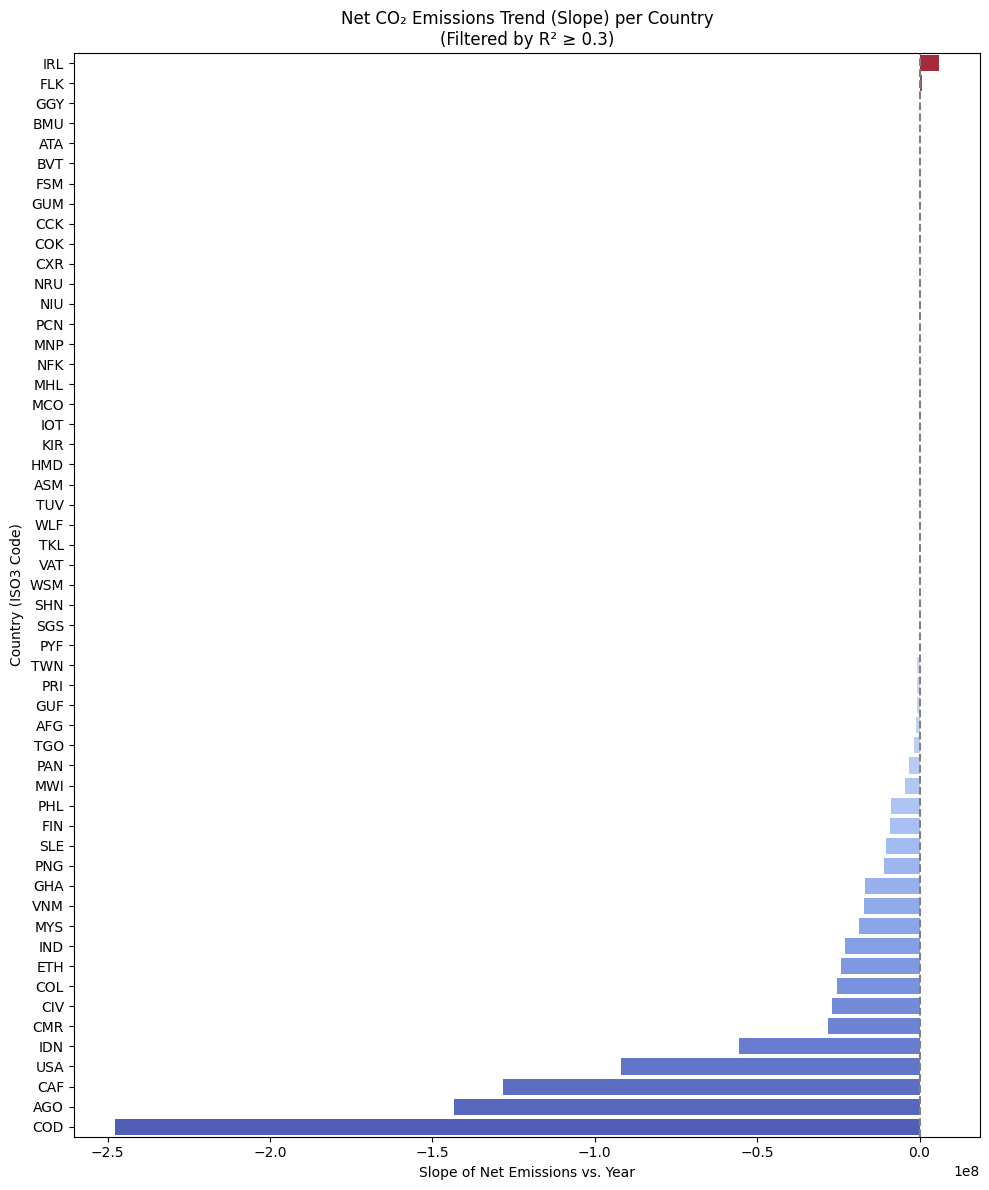

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter: Keep only countries with a decent fit (R² ≥ 0.3)
reliable_trends = regression_results[regression_results['r_squared'] >= 0.3].copy()

# Sort by slope value
reliable_trends_sorted = reliable_trends.sort_values(by='slope', ascending=False)

# Set up the plot
plt.figure(figsize=(10, 12))
sns.barplot(
    x='slope',
    y='iso3_country',
    data=reliable_trends_sorted,
    palette='coolwarm_r',
    orient='h'
)

# Add labels and title
plt.axvline(0, color='gray', linestyle='--')  # Neutral reference line
plt.title('Net CO₂ Emissions Trend (Slope) per Country\n(Filtered by R² ≥ 0.3)')
plt.xlabel('Slope of Net Emissions vs. Year')
plt.ylabel('Country (ISO3 Code)')
plt.tight_layout()
plt.show()


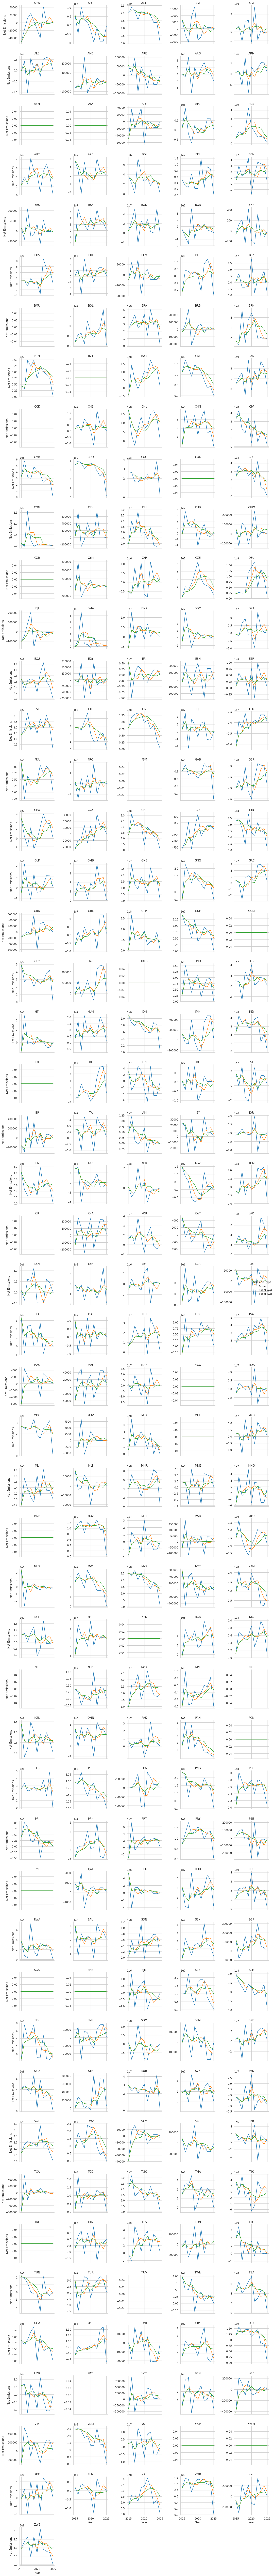

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to countries with at least 5 years of data to avoid sparse plots
country_counts = trend_df['iso3_country'].value_counts()
valid_countries = country_counts[country_counts >= 5].index
filtered_df = trend_df[trend_df['iso3_country'].isin(valid_countries)]

# Melt the DataFrame to long format for easier plotting with seaborn
melted_df = pd.melt(
    filtered_df,
    id_vars=['iso3_country', 'year'],
    value_vars=['net_emissions', 'net_emissions_3yr_avg', 'net_emissions_5yr_avg'],
    var_name='emission_type',
    value_name='value'
)

# Map emission type to readable labels
emission_labels = {
    'net_emissions': 'Actual',
    'net_emissions_3yr_avg': '3-Year Avg',
    'net_emissions_5yr_avg': '5-Year Avg'
}
melted_df['emission_type'] = melted_df['emission_type'].map(emission_labels)

# Plot using FacetGrid
sns.set(style="whitegrid")
g = sns.FacetGrid(
    melted_df,
    col="iso3_country",
    col_wrap=5,
    height=3,
    sharey=False
)
g.map_dataframe(
    sns.lineplot,
    x="year",
    y="value",
    hue="emission_type",
    palette="tab10"
)

# Add titles and legends
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Year", "Net Emissions")
g.add_legend(title="Emission Type")
plt.tight_layout()
plt.show()


<ipython-input-23-ba3b1898722a>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='net_emissions', y='iso3_country', data=top_emitters, palette='Reds_r')


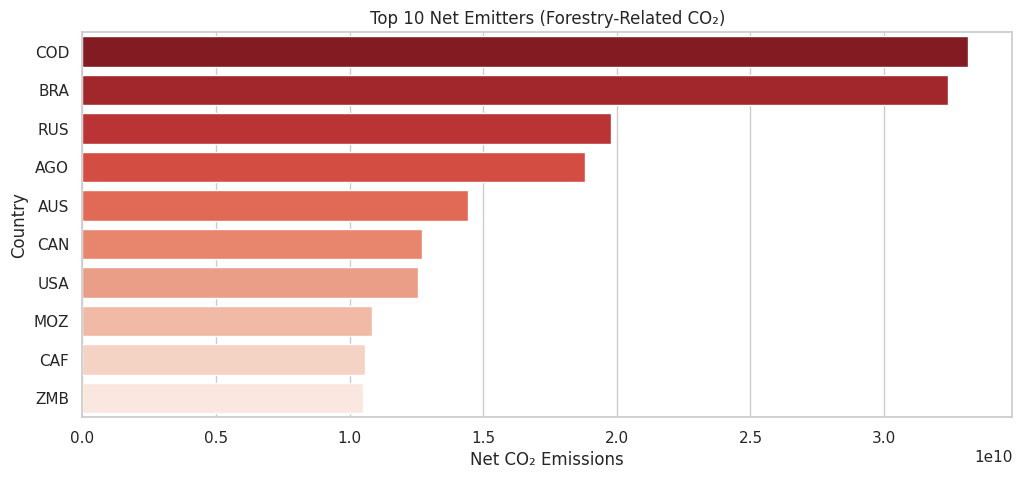

<ipython-input-23-ba3b1898722a>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='removals', y='iso3_country', data=top_removers, palette='Greens')


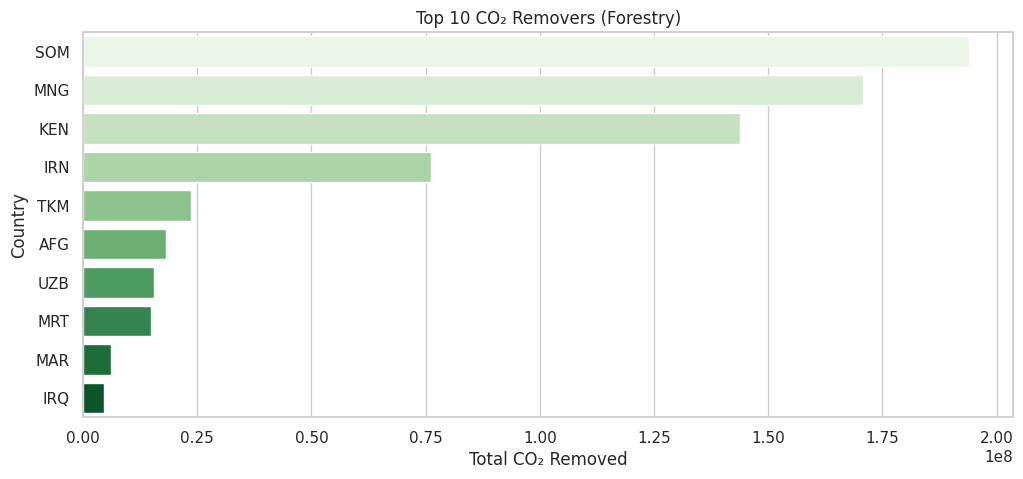

In [ ]:
# Group by country over all years
country_totals = merged_df.groupby('iso3_country').agg({
    'fire_emissions': 'sum',
    'deforestation_emissions': 'sum',
    'removals': 'sum',
    'net_emissions': 'sum'
}).reset_index()

# Top 10 emitters
top_emitters = country_totals.sort_values(by='net_emissions', ascending=False).head(10)

# Top 10 removers
top_removers = country_totals.sort_values(by='removals', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x='net_emissions', y='iso3_country', data=top_emitters, palette='Reds_r')
plt.title('Top 10 Net Emitters (Forestry-Related CO₂)')
plt.xlabel('Net CO₂ Emissions')
plt.ylabel('Country')
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(x='removals', y='iso3_country', data=top_removers, palette='Greens')
plt.title('Top 10 CO₂ Removers (Forestry)')
plt.xlabel('Total CO₂ Removed')
plt.ylabel('Country')
plt.show()


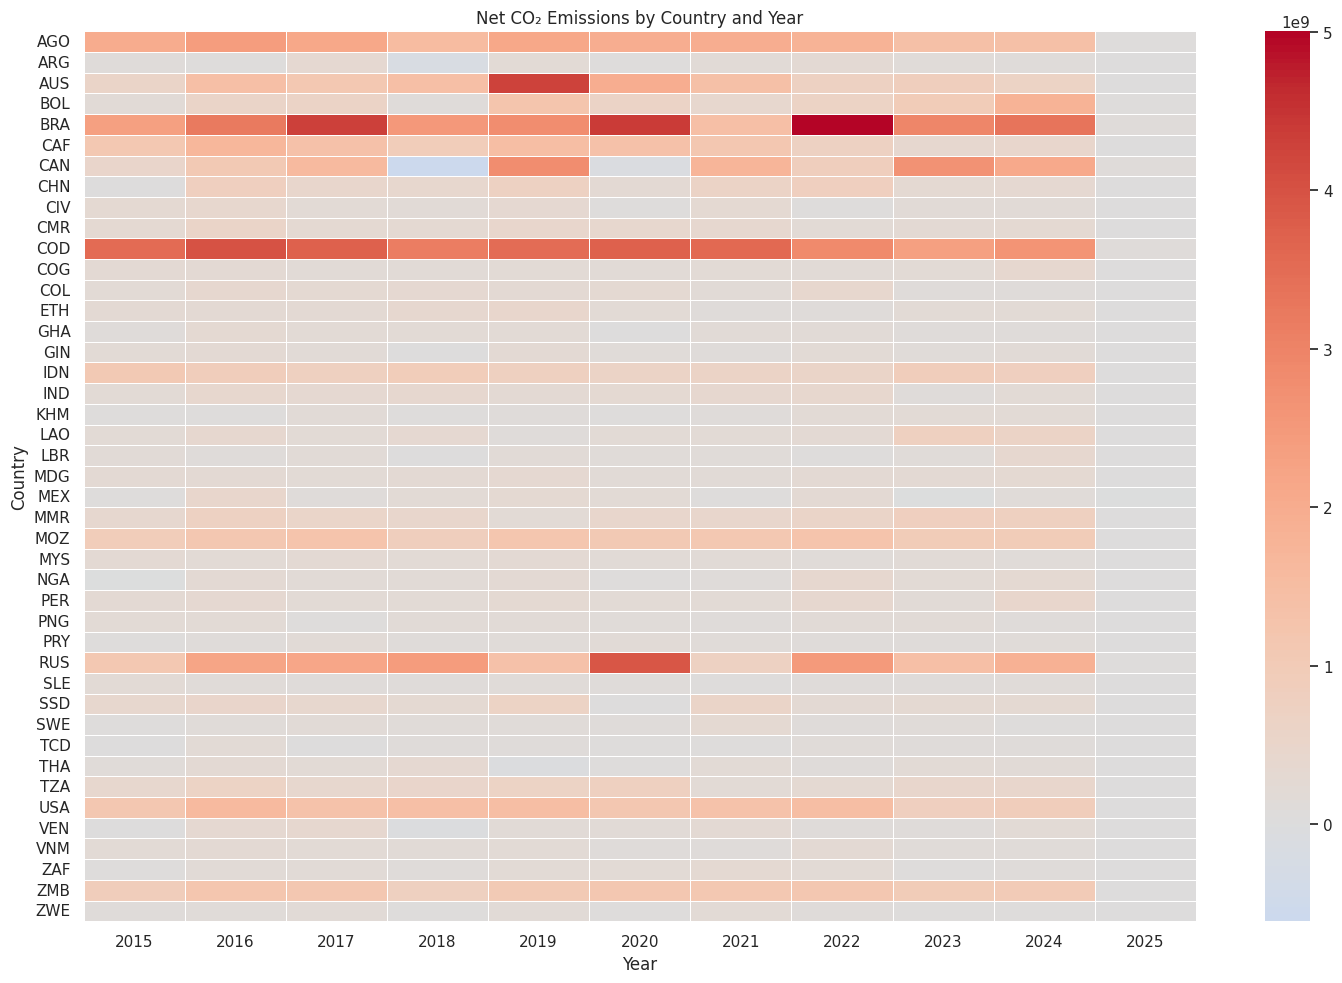

In [ ]:
# Option: Filter to countries with significant total emissions
threshold = 1000000000    # adjust based on your data scale
significant_countries = merged_df.groupby('iso3_country')['net_emissions'].sum()
significant_countries = significant_countries[significant_countries.abs() > threshold].index

filtered = merged_df[merged_df['iso3_country'].isin(significant_countries)]

# Pivot again for heatmap
pivot = filtered.pivot(index='iso3_country', columns='year', values='net_emissions')

plt.figure(figsize=(15, 10))
sns.heatmap(pivot, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Net CO₂ Emissions by Country and Year')
plt.xlabel('Year')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

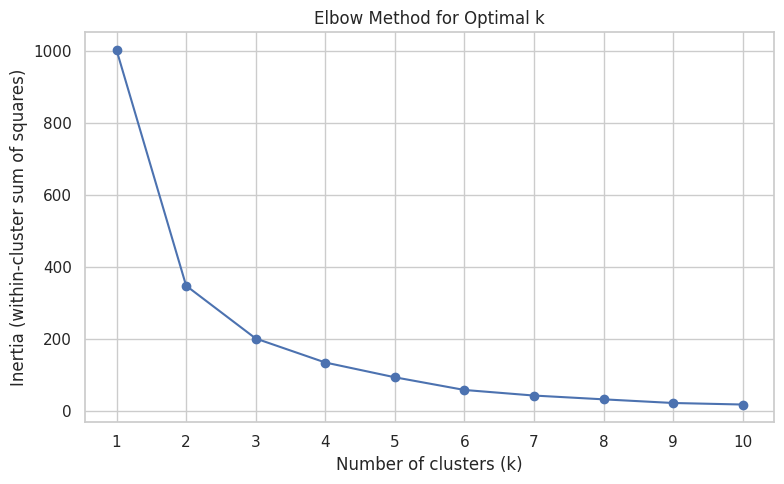

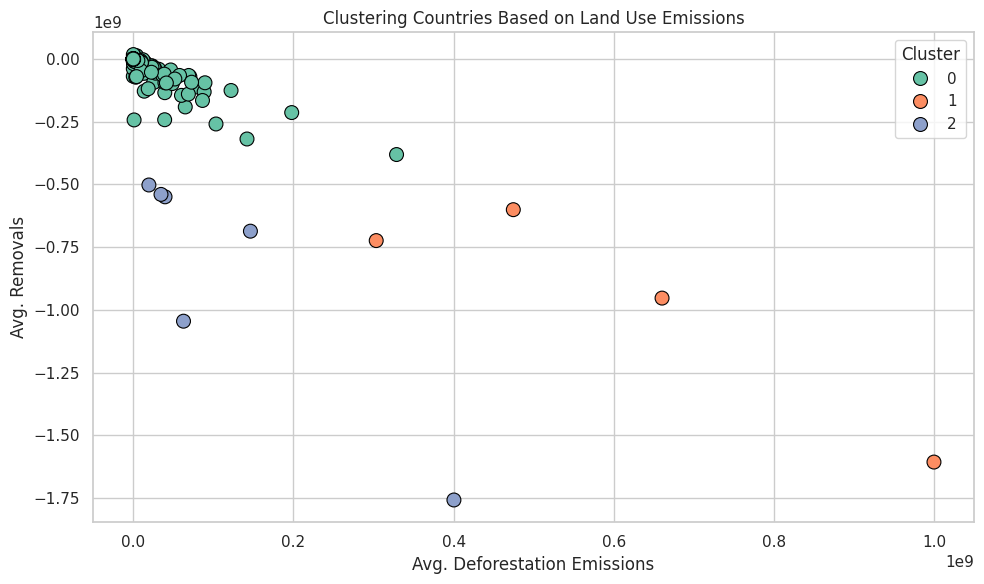

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Group and average emissions data per country
country_avg = merged_df.groupby('iso3_country').agg({
    'fire_emissions': 'mean',
    'deforestation_emissions': 'mean',
    'removals': 'mean',
    'net_emissions': 'mean'
}).dropna()

# --- Step 2: Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(country_avg)

# Select your features (already averaged per country)
features = ['fire_emissions', 'deforestation_emissions', 'removals', 'net_emissions']
X = country_avg[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate inertia (sum of squared distances) for k = 1 to 10
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 3: Run KMeans clustering
k = 3  # You can try different values (elbow method or silhouette score helps)
kmeans = KMeans(n_clusters=k, random_state=42)
country_avg['cluster'] = kmeans.fit_predict(scaled_features)

# --- Step 4: Plot clusters in 2D (you can switch to PCA if you want dimensionality reduction)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=country_avg,
    x='deforestation_emissions',
    y='removals',
    hue='cluster',
    palette='Set2',
    s=100,
    edgecolor='black'
)
plt.title('Clustering Countries Based on Land Use Emissions')
plt.xlabel('Avg. Deforestation Emissions')
plt.ylabel('Avg. Removals')
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


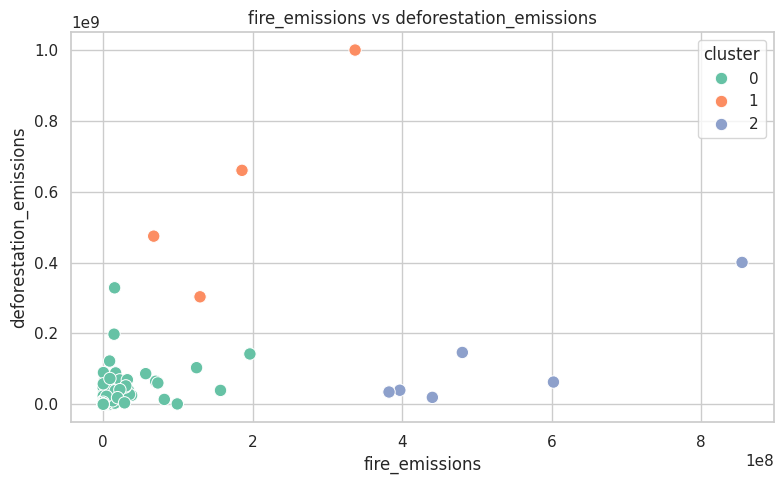

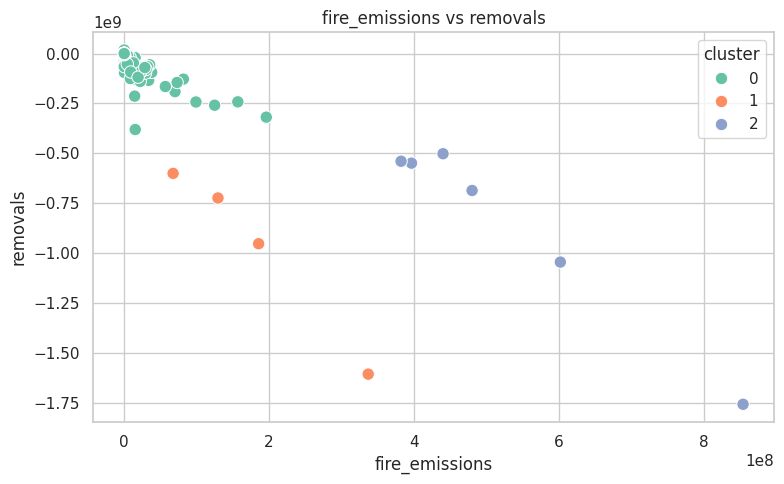

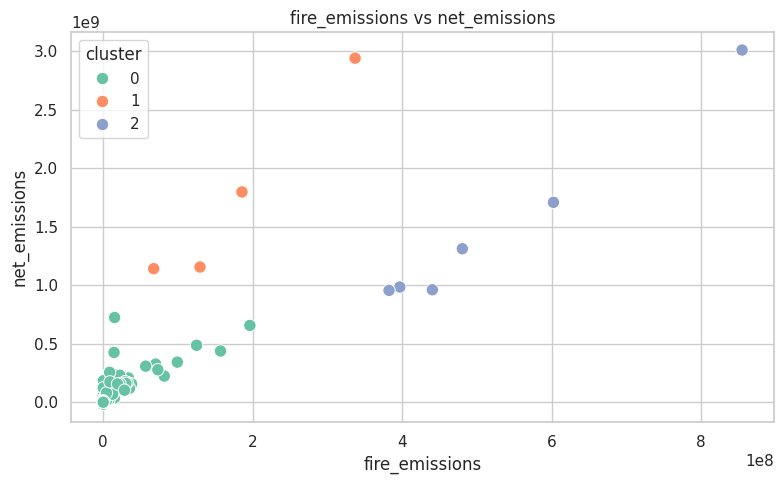

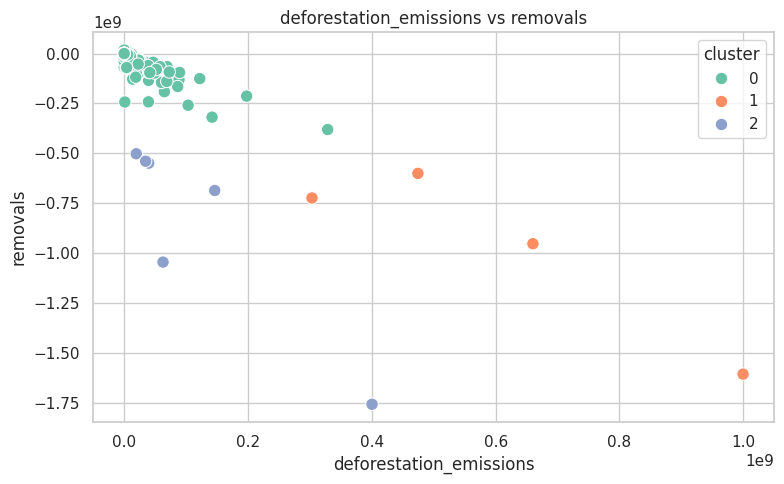

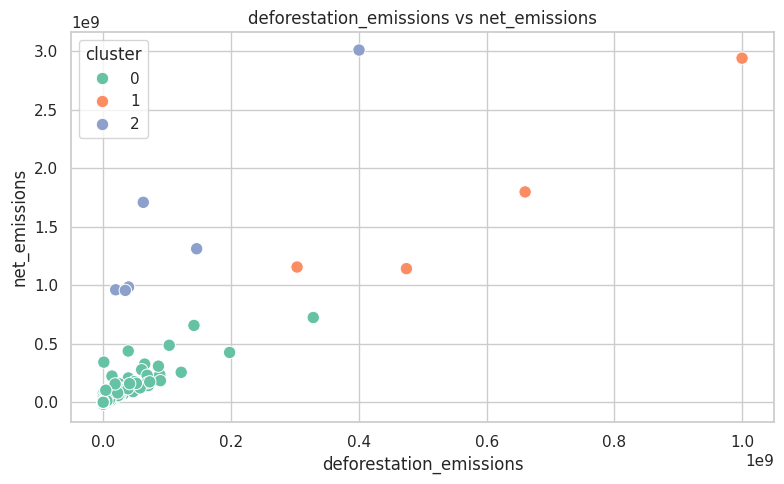

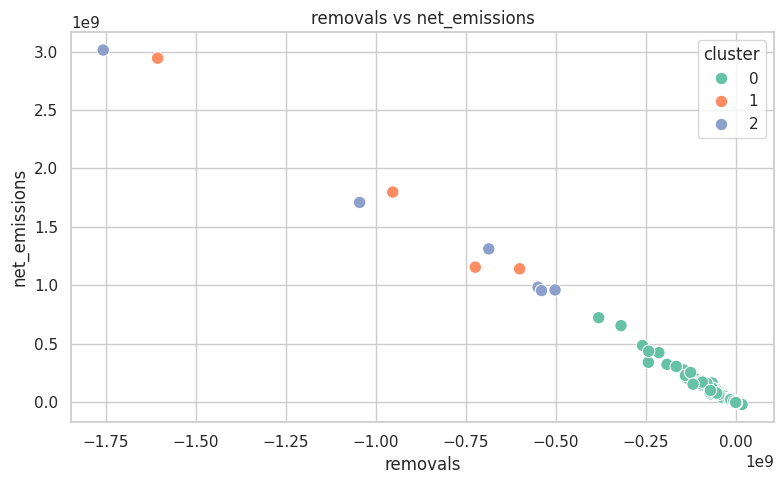

In [ ]:
import itertools

pairs = list(itertools.combinations(['fire_emissions', 'deforestation_emissions', 'removals', 'net_emissions'], 2))

for x, y in pairs:
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=country_avg, x=x, y=y, hue='cluster', palette='Set2', s=80)
    plt.title(f'{x} vs {y}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


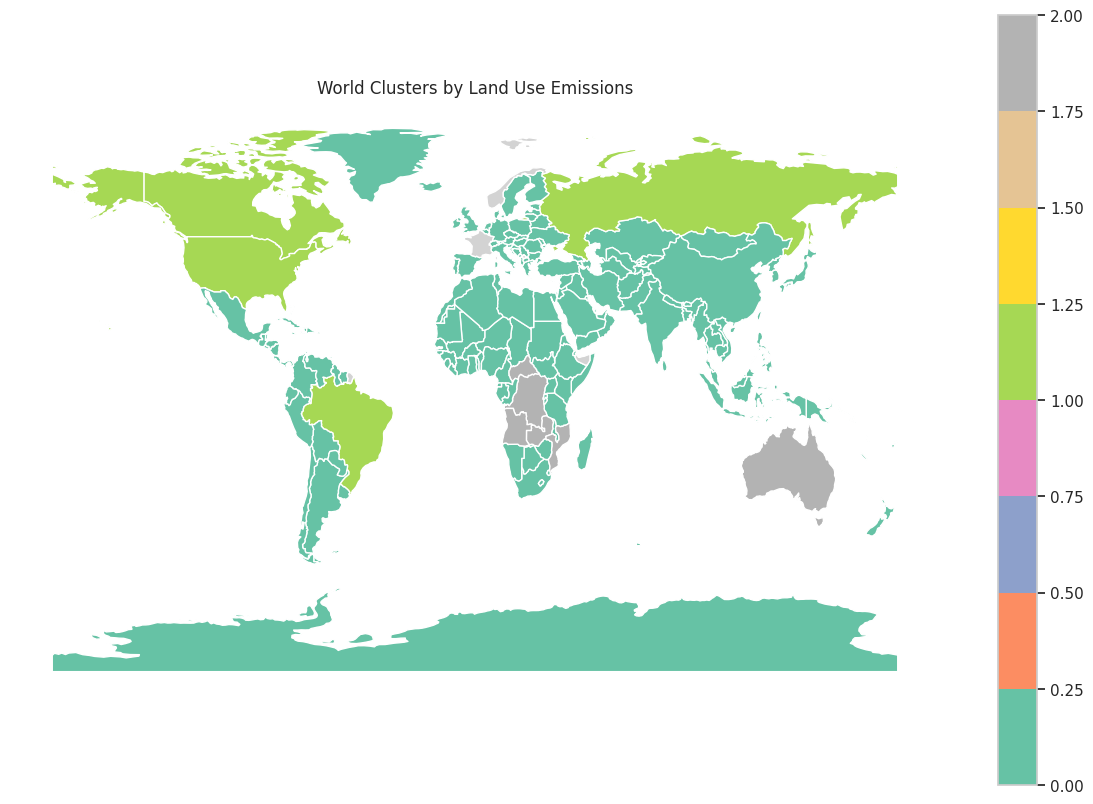

In [ ]:
!pip install geopandas
import geopandas as gpd
import requests
import zipfile
import io

# Download the Natural Earth shapefile (smaller, lower resolution version)
url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"  # Smaller version
response = requests.get(url, stream=True)
response.raise_for_status()  # Raise an exception for bad responses

# Extract the shapefile
with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
    zf.extractall("shapefile_data")  # Extract to a folder

# Load the downloaded shapefile
world = gpd.read_file("shapefile_data/ne_110m_admin_0_countries.shp")

# Merge with cluster data
world = world.merge(country_avg['cluster'], how='left', left_on='ISO_A3', right_on=country_avg.index)

# Plot map
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(column='cluster', ax=ax, legend=True, cmap='Set2', missing_kwds={'color': 'lightgrey'})
ax.set_title('World Clusters by Land Use Emissions')
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

trend_features = []

# Use merged_df instead of df in the loop
for country, group in merged_df.groupby('iso3_country'):
    group = group.sort_values('year')

    # Trend slope for fire emissions
    x = group['year'].values.reshape(-1, 1)

    y_fire = group['fire_emissions'].values
    y_def = group['deforestation_emissions'].values
    y_rem = group['removals'].values
    y_net = group['net_emissions'].values

    slope_fire = LinearRegression().fit(x, y_fire).coef_[0]
    slope_def = LinearRegression().fit(x, y_def).coef_[0]
    slope_rem = LinearRegression().fit(x, y_rem).coef_[0]
    slope_net = LinearRegression().fit(x, y_net).coef_[0]

    trend_features.append({
        'country': country,
        'slope_fire': slope_fire,
        'slope_deforestation': slope_def,
        'slope_removals': slope_rem,
        'slope_net': slope_net
    })

import pandas as pd
trend_df = pd.DataFrame(trend_features).set_index('country')


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_scaled = scaler.fit_transform(trend_df)

kmeans = KMeans(n_clusters=3, random_state=0)
trend_df['cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
for cluster_id in range(3):
    print(f"\nCluster {cluster_id}:")
    print(trend_df[trend_df['cluster'] == cluster_id].index.tolist())



Cluster 0:
['ABW', 'AFG', 'AIA', 'ALA', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM', 'ATA', 'ATF', 'ATG', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BES', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLM', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRB', 'BRN', 'BTN', 'BVT', 'BWA', 'CAN', 'CCK', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COG', 'COK', 'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CUW', 'CXR', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR', 'GEO', 'GGY', 'GHA', 'GIB', 'GIN', 'GLP', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL', 'GTM', 'GUF', 'GUM', 'GUY', 'HKG', 'HMD', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IMN', 'IND', 'IOT', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LIE', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC', 'MAF', 'MAR', 'MCO', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD', 'MLI', 